# Multi Agent Deep Deterministic Policy Gradients (DDPG)
---
In this notebook, we solve Unity's Tennis environment using a multi agent version of the DDPG algorithm.

### 1. Import the Necessary Packages

We commence by importing the required packages. (Notice that ddpg_agent.py encapsulates the details of the learning agent.):

In [1]:
from unityagents import UnityEnvironment

import numpy as np
import torch
import random

from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

import time
from datetime import timedelta

from maddpg_agent import Agent

### 2. Instantiate the Environment and Agent

Environments contain brains deciding which actions the agents should take. Here, we first work with the Tennis environment which contains two agents. The first brain available is set as the default brain (see the second to next code cell).

In [2]:
env = UnityEnvironment(file_name="/Users/Andreas/Documents/GitHub/deep-reinforcement-learning/p3_collab-compet/Solution/Tennis.app",worker_id=1, seed=1,no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 3. Examination of the state and action spaces

In this problem two agents have tennis rackets to shoot a ball over a net. In case an agent is able to hit the ball over the net, a reward of +0.1 is released. Whenever an agent misses the ball and it falls to the ground or if the ball is played outside of the bounds, a negative reward of -0.01 is released. 

The overall goal of the agents is thus to keep playing the ball over the net for as long as possible.

The observation space has 8 (continuous) variables which correspond to the position and velocity of the ball and the racket. An agent can take two continuous actions (of values in the interval [-1,1]) which correspond to moving towards the net or away from it, as well as jumping.

The following cell contains some overview information about the environment:

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
number_agents = len(env_info.agents)
print('Number of agents:', number_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There is/are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print("\n")
for i in range(0,states.shape[0]):
    print('The state for agent {} looks like:\n'.format(i+1), states[i])
    print("\n")


Number of agents: 2
Size of each action: 2
There is/are 2 agents. Each observes a state with length: 24


The state for agent 1 looks like:
 [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.63803244 -1.5
 -0.          0.          6.00063038  6.         -0.          0.        ]


The state for agent 2 looks like:
 [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -7.07908773 -1.5
  0.          0.         -6.00063038  6.          0.          0.        ]




### 4. Training of the agents with Multi Agent DDPG

The following function is responsible for the training of the agents. The agents are trained so that they use their experience to gradually choose better actions over time. Once the agents reach an average score of 0.5 over 100 consecutive episodes, the learned weights are saved to the checkpoint_actor.pth and checkpoint_critic.pth files and the environment is solved. Notice that the details of the actor and critic part of the algorithm and their training are taken care of the model.py and ddpg_agent.py files.

We then initialize the agents, train them, define moving average functions (needed for plotting), and plot the results below.

In [5]:
def maddpg(n_episodes=10000, max_t=1000, print_every=100):

    scores_deque = deque(maxlen=print_every)                    # We define a linked list to store the last 100 scores. This is our moving window.
    scores= []                                                  # We define a list to keep all scores.
    
    print('\rThe number of agents amounts to ' + str(agents.number_agents) + "." + "\n") # We print the number of agents available in the environment.
    
    starting_time = time.time()                                 # We set the starting time needed to document how much time is required to solve the environment.
    
    for i_episode in range(1, n_episodes + 1):

        # Per episode we have to reset the environment.
        env_info = env.reset(train_mode=True)[brain_name]
        # Per episode we have to get the current state.
        state = env_info.vector_observations
        
        
        score = np.zeros(number_agents)                         # We initialize the score for each given agent.
        agents.reset()                                          # We reset each agent.

        for t in range(max_t):
            
            actions = agents.act(state)
            
            env_info = env.step(actions)[brain_name]
            # We obtain the next state.
            next_state = env_info.vector_observations
            # We get the reward.
            rewards = env_info.rewards
            # We get the done status.
            dones = env_info.local_done
            
            
            agents.step(state, actions, rewards, next_state, dones) # We proceed to the next step.

            state = next_state                                  # We set state to next state.
            score += np.max(rewards)                            # We add the maximum of the rewards up to the score.

            # Print current data to see progress in realtime

            print('\rEpisode {}\tTimestep {}\tMaximum score: {:.2f}'
                  .format(i_episode, t, np.max(score)), end="")

            if np.any(dones):                                   # if any done, break out of the loop.
                break

        # After each episode, we add up the rewards that each agent received (without discounting), 
        # to get a score for each agent. This yields 2 (potentially different) scores. 
        # We then take the maximum of these 2 scores.
        scores_deque.append(np.max(score))
        scores.append(np.max(score))
                    
        if i_episode % 10 == 0:
            overall_time = str(timedelta(seconds=time.time() - starting_time))
            print('\rEpisode {}\tAverage Score: {:.2f}\tTime needed: {}'.format(i_episode, np.mean(scores_deque),overall_time))       
            
        # When the average over 100 episodes exceeds a threshold we break, print the result and the time needed.    
        if np.mean(scores_deque) >= 0.5:

            overall_time = str(timedelta(seconds=time.time() - starting_time))
            
            print("\r\rThe enviroment was solved in {i_episode} episodes,"
                  "with an average score over 100 consecutive episodes of {average_score:.2f}.\t The time needed was {overall_time}.\r"
                  .format(i_episode=i_episode, average_score=np.mean(scores_deque), overall_time=overall_time))

            # We save the weights of the actor and critic model.
            torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth')

            break

    return scores

We proceed with the actual training of the agents. A plot of rewards per episode is included which illustrates that the agent is able to receive an average reward (over 100 episodes) of at least +0.5. We also report the number of episodes which are needed to solve the environment. In addition, we print the type of noise used and the network architectures of the actor and critic models employed to obtain the results.

In [6]:
# We call the Agent class and initialize the learning agents.
agents = Agent(state_size=state_size, action_size=action_size, number_agents=number_agents, random_seed=0)

# We give the architectures of the actor and critic networks.
print('-----------ACTOR NETWORK-----------')
print(agents.actor_local)
print('\n')
print('-----------CRITIC NETWORK-----------')
print(agents.critic_local)
print("\n")


# We then start the learning algorithm.
scores = maddpg()



~~~OU NOISE RUNNING~~~


-----------ACTOR NETWORK-----------
Actor(
  (fc1): Linear(in_features=24, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


-----------CRITIC NETWORK-----------
Critic(
  (fc1): Linear(in_features=24, out_features=512, bias=True)
  (fc2): Linear(in_features=514, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)


The number of agents amounts to 2.

Episode 1	Timestep 15	Maximum score: 0.00

/Users/Andreas/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 10	Average Score: 0.02	Time needed: 0:00:03.353408
Episode 20	Average Score: 0.01	Time needed: 0:00:06.783864
Episode 30	Average Score: 0.01	Time needed: 0:00:10.199259
Episode 40	Average Score: 0.01	Time needed: 0:00:13.572034
Episode 50	Average Score: 0.00	Time needed: 0:00:17.077601
Episode 60	Average Score: 0.00	Time needed: 0:00:20.640090
Episode 70	Average Score: 0.00	Time needed: 0:00:24.147025
Episode 80	Average Score: 0.00	Time needed: 0:00:27.630775
Episode 90	Average Score: 0.00	Time needed: 0:00:31.132084
Episode 100	Average Score: 0.00	Time needed: 0:00:34.669510
Episode 110	Average Score: 0.00	Time needed: 0:00:38.173028
Episode 120	Average Score: 0.00	Time needed: 0:00:41.662503
Episode 130	Average Score: 0.00	Time needed: 0:00:45.150956
Episode 140	Average Score: 0.00	Time needed: 0:00:48.675933
Episode 150	Average Score: 0.00	Time needed: 0:00:52.233170
Episode 160	Average Score: 0.00	Time needed: 0:00:55.778721
Episode 170	Average Score: 0.00	Time needed: 0:00

Episode 1370	Average Score: 0.02	Time needed: 0:10:11.861663
Episode 1380	Average Score: 0.03	Time needed: 0:10:20.271387
Episode 1390	Average Score: 0.04	Time needed: 0:10:27.459314
Episode 1400	Average Score: 0.04	Time needed: 0:10:35.494390
Episode 1410	Average Score: 0.05	Time needed: 0:10:41.741705
Episode 1420	Average Score: 0.05	Time needed: 0:10:49.740439
Episode 1430	Average Score: 0.06	Time needed: 0:10:57.837159
Episode 1440	Average Score: 0.07	Time needed: 0:11:08.150407
Episode 1450	Average Score: 0.07	Time needed: 0:11:15.223755
Episode 1460	Average Score: 0.07	Time needed: 0:11:24.779696
Episode 1470	Average Score: 0.07	Time needed: 0:11:34.284606
Episode 1480	Average Score: 0.07	Time needed: 0:11:40.335007
Episode 1490	Average Score: 0.07	Time needed: 0:11:49.964722
Episode 1500	Average Score: 0.07	Time needed: 0:11:56.945913
Episode 1510	Average Score: 0.07	Time needed: 0:12:04.649776
Episode 1520	Average Score: 0.06	Time needed: 0:12:10.594381
Episode 1530	Average Sco

In [7]:
# Define moving average functions for plotting below.
# Handy info on moving averages is found on https://www.quora.com/How-do-I-perform-moving-average-in-Python.

def movingaverage(values,window):
    weights = np.repeat(1.0,window)/window
    smas = np.convolve(values,weights,'valid')
    return smas

def ExpMovingAverage(values,window):
    weights = np.exp(np.linspace(-1.,0.,window))
    weights /= weights.sum()
    
    emas = np.convolve(values,weights)[:len(values)]
    emas[:window] = emas[window]
    return emas

def Gaussianwindowsaverage(values):
    gaussian_func = lambda x, sigma: 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(x**2)/(2*sigma**2))
    # Compute moving averages using window size sigma_lst
    sigma_lst = 3
    y_gau = np.zeros((1, len(values)))

    gau_x = np.linspace(-2.7*sigma_lst, 2.7*sigma_lst, 6*sigma_lst)
    gau_mask = gaussian_func(gau_x, sigma_lst)
    y_gau = np.convolve(values, gau_mask, 'same')
    
    return y_gau

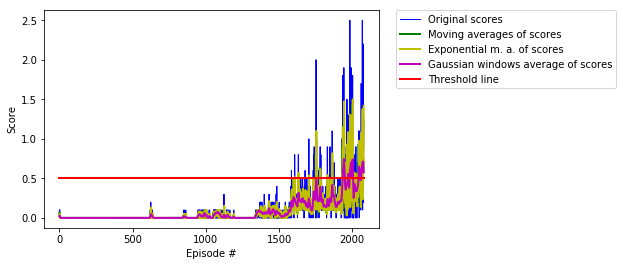

In [8]:
# We plot the scores over the number of episodes.
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(scores, 'b', lw=1, label='Original scores')
plt.plot(movingaverage(scores,3), 'g', lw=2, label='Moving averages of scores')
plt.plot(ExpMovingAverage(scores,3), 'y', lw=2, label='Exponential m. a. of scores')
plt.plot(Gaussianwindowsaverage(scores),'m',lw=2, label='Gaussian windows average of scores')
plt.plot([0, len(scores)], [0.5, 0.5], 'r', lw=2,  label='Threshold line')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### 5. Watch the Smart Agents!

In the following code cell, one can load the trained weights from the files in order to watch the performance of the smart (i.e. trained) agent(s).

In [12]:
agents.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agents.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]   # reset the environment
state = env_info.vector_observations                 # get the current state
score = np.zeros(number_agents)                      # initialize the scores

while True:
    actions = agents.act(state)                      # select the actions
    env_info = env.step(actions)[brain_name]         # send the actions to the environment
    next_state = env_info.vector_observations        # get the next state
    rewards = env_info.rewards                       # get the rewards
    dones = env_info.local_done                      # see if episode has finished
    score += rewards                                 # update the score
    state = next_state                               # roll over the state to next time step
    if np.any(dones):                                # exit loop if episode is finished
        break
    
print("Scores for the agents: {:.2f}, {:.2f}. ".format(round(score[0],2), round(score[1],2))) # print the scores of the episode

Scores for the agents: 0.79, 0.90. 


### 6. Closing the environment

In the last step, we close the environment.

In [ ]:
env.close()